# Prediction of Product Sales

**Chelsey Combe**


## Project Overview

The goal of this analysis will be a sales prediction for food items sold at various stores. The goal of this is to help the retailer understand the properties of products and outlets that play crucial roles in increasing sales.


Link to original dataset: https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/


## Data Dictionary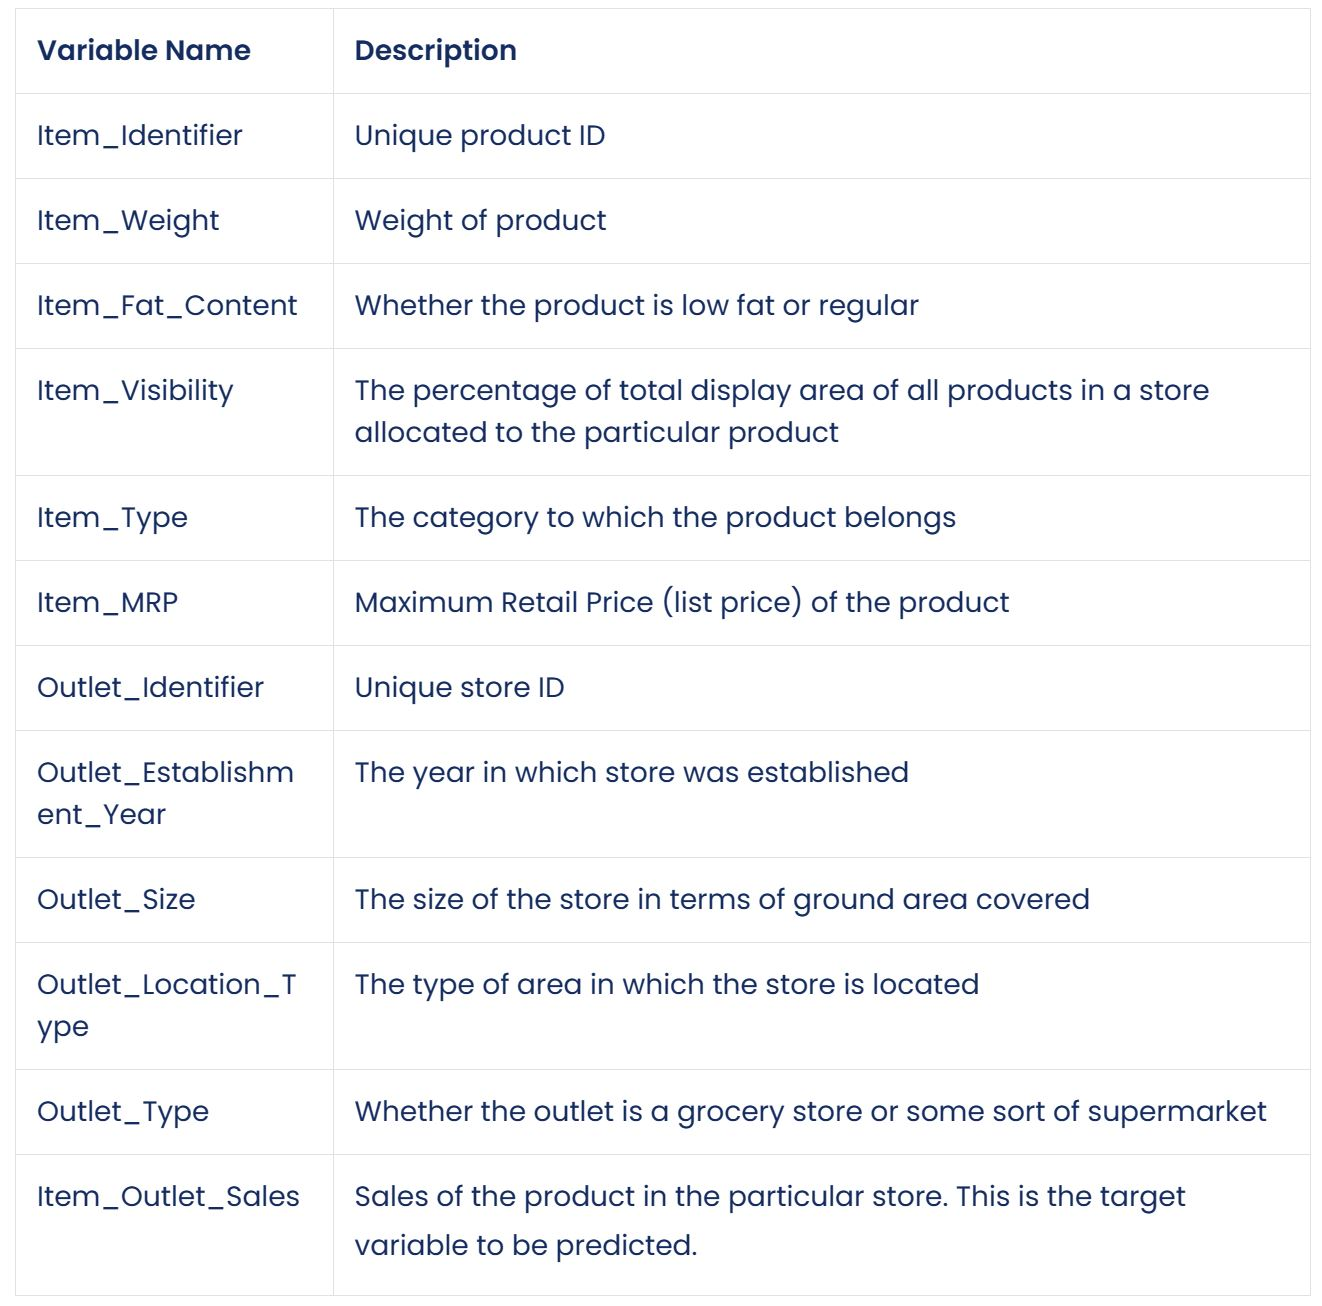

## Imports

In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
import os

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)

## set pandas to display more columns
pd.set_option('display.max_columns',50)

import warnings
warnings.filterwarnings('ignore')

plt.style.use(['seaborn-muted','fivethirtyeight'])
sns.set_context('talk')

In [2]:
# Define the custom style
custom_style = {
    'axes.edgecolor': 'grey',         # Color of the axes edges
    'axes.grid': True,                # Show gridlines on the plot
    'grid.color': 'lightgrey',        # Color of the gridlines
    'axes.spines.left': False,        # Turn off the left spine (border of the plot)
    'axes.spines.right': False,       # Turn off the right spine
    'axes.spines.top': False,         # Turn off the top spine
    'axes.facecolor': 'white',        # Background color of the plot
}

# Set the custom style
sns.set_style(custom_style)

grocery_palette = ['#4CAF50',   # Green (Leafy Green)
                  '#FF9800',   # Orange (Citrus Orange)
                  '#FFEB3B',   # Yellow (Sunny Yellow)
                  '#00BCD4',   # Aqua Blue (Fresh Blue)
                  '#FF5722',   # Coral (Vibrant Coral)
                  '#E91E63']   # Raspberry (Ripe Raspberry)

# Set the custom color palette
sns.set_palette(grocery_palette)

In [3]:
# example making new folder with os
os.makedirs('Data/',exist_ok=True) # Confirm folder created
os.listdir("Data/")

['sales_predictions_2023(1).csv']

## Load Data

In [4]:
# Construct the path using os.path.join()
data_folder = "Data"
file_name = "sales_predictions_2023(1).csv"
file_path = os.path.join(data_folder, file_name)

# Load the CSV file
df = pd.read_csv(file_path)


In [5]:
#Saving original dataset as 'df2'
df2 = df.copy()

df.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

## Clean Data

In [6]:
#Checking for duplicate rows within dataset
df.duplicated().sum()

0

In [7]:
# Deleting the "Item_Identifier" column in place
df.drop("Item_Identifier", axis=1, inplace=True)


# Deleting the "Item_Identifier" column in place
df.drop("Item_Visibility", axis=1, inplace=True)

In [8]:
#Standardizing variations of "Low Fat" and "Regular"
df["Item_Fat_Content"] = df["Item_Fat_Content"].str.replace("LF", "Low Fat")
df["Item_Fat_Content"] = df["Item_Fat_Content"].str.replace("low fat", "Low Fat")
df["Item_Fat_Content"] = df["Item_Fat_Content"].str.replace("reg", "Regular")

#Verifying that replacements were made
df["Item_Fat_Content"].value_counts()

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

**Remake your X_train and X_test as DataFrames with the feature names extracted from the column transformer instead of combining your preprocessor and model into 1 pipeline.**

In [9]:
## Define X and y
target = 'Item_Outlet_Sales'

## Make x and y variables
y = df[target].copy()
X = df.drop(columns=[target]).copy()
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

Item_Weight Item_Fat_Content              Item_Type  Item_MRP  \
8269        7.220          Regular           Baking Goods   61.2510   
7604        6.135          Low Fat            Soft Drinks  111.2860   
2762       12.150          Low Fat              Household  151.0708   
6464        5.945          Low Fat              Household  127.8652   
4707       18.200          Regular  Fruits and Vegetables  247.2092   

     Outlet_Identifier  Outlet_Establishment_Year Outlet_Size  \
8269            OUT010                       1998         NaN   
7604            OUT018                       2009      Medium   
2762            OUT035                       2004       Small   
6464            OUT035                       2004       Small   
4707            OUT035                       2004       Small   

     Outlet_Location_Type        Outlet_Type  
8269               Tier 3      Grocery Store  
7604               Tier 3  Supermarket Type2  
2762               Tier 2  Supermarket Type1  
6464               Tier 2  Supermarket Type1  
4707               Tier 2  Supermarket Type1

In [10]:
## make categorical selector and verify it works 
cat_sel = make_column_selector(dtype_include='object')
cat_sel(X_train)

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [11]:
## make numeric selector and verify it works 
num_sel = make_column_selector(dtype_include='number')
num_sel(X_train)

['Item_Weight', 'Item_MRP', 'Outlet_Establishment_Year']

In [12]:
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

In [13]:
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),                                      
                                       verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000285C9010640>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000285C8FDF730>)],
                  verbose_feature_names_out=False)

In [14]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['Item_Weight', 'Item_MRP', 'Outlet_Establishment_Year',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Type_Baking Goods', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
       'Outlet_Size_High', 'Outlet_Size_MISSING', 'Outlet_Size_Medium',
       'Outlet_Size_Small', 'Outlet_Location_Type_Tie

In [15]:
# Create processed dataframe for training set
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_train_df.head(3)

Item_Weight  Item_MRP  Outlet_Establishment_Year  \
8269        7.220   61.2510                     1998.0   
7604        6.135  111.2860                     2009.0   
2762       12.150  151.0708                     2004.0   

      Item_Fat_Content_Low Fat  Item_Fat_Content_Regular  \
8269                       0.0                       1.0   
7604                       1.0                       0.0   
2762                       1.0                       0.0   

      Item_Type_Baking Goods  Item_Type_Breads  Item_Type_Breakfast  \
8269                     1.0               0.0                  0.0   
7604                     0.0               0.0                  0.0   
2762                     0.0               0.0                  0.0   

      Item_Type_Canned  Item_Type_Dairy  Item_Type_Frozen Foods  \
8269               0.0              0.0                     0.0   
7604               0.0              0.0                     0.0   
2762               0.0              0.0                     0.0   

      Item_Type_Fruits and Vegetables  Item_Type_Hard Drinks  \
8269                              0.0                    0.0   
7604                              0.0                    0.0   
2762                              0.0                    0.0   

      Item_Type_Health and Hygiene  Item_Type_Household  Item_Type_Meat  \
8269                           0.0                  0.0             0.0   
7604                           0.0                  0.0             0.0   
2762                           0.0                  1.0             0.0   

      Item_Type_Others  Item_Type_Seafood  Item_Type_Snack Foods  \
8269               0.0                0.0                    0.0   
7604               0.0                0.0                    0.0   
2762               0.0                0.0                    0.0   

      Item_Type_Soft Drinks  Item_Type_Starchy Foods  \
8269                    0.0                      0.0   
7604                    1.0                      0.0   
2762                    0.0                      0.0   

      Outlet_Identifier_OUT010  Outlet_Identifier_OUT013  \
8269                       1.0                       0.0   
7604                       0.0                       0.0   
2762                       0.0                       0.0   

      Outlet_Identifier_OUT017  Outlet_Identifier_OUT018  \
8269                       0.0                       0.0   
7604                       0.0                       1.0   
2762                       0.0                       0.0   

      Outlet_Identifier_OUT019  Outlet_Identifier_OUT027  \
8269                       0.0                       0.0   
7604                       0.0                       0.0   
2762                       0.0                       0.0   

      Outlet_Identifier_OUT035  Outlet_Identifier_OUT045  \
8269                       0.0                       0.0   
7604                       0.0                       0.0   
2762                       1.0                       0.0   

      Outlet_Identifier_OUT046  Outlet_Identifier_OUT049  Outlet_Size_High  \
8269                       0.0                       0.0               0.0   
7604                       0.0                       0.0               0.0   
2762                       0.0                       0.0               0.0   

      Outlet_Size_MISSING  Outlet_Size_Medium  Outlet_Size_Small  \
8269                  1.0                 0.0                0.0   
7604                  0.0                 1.0                0.0   
2762                  0.0                 0.0                1.0   

      Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
8269                          0.0                          0.0   
7604                          0.0                          0.0   
2762                          0.0                          1.0   

      Outlet_Location_Type_Tier 3  Outlet_Type_Grocery Store  \
8269                          1.0          

In [16]:
# Create processed dataframe for test set
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(3)

Item_Weight  Item_MRP  Outlet_Establishment_Year  \
8077        15.25  132.2968                     2007.0   
2391        17.85  127.1020                     1997.0   
163          7.27  114.2518                     1997.0   

      Item_Fat_Content_Low Fat  Item_Fat_Content_Regular  \
8077                       1.0                       0.0   
2391                       1.0                       0.0   
163                        1.0                       0.0   

      Item_Type_Baking Goods  Item_Type_Breads  Item_Type_Breakfast  \
8077                     0.0               0.0                  0.0   
2391                     0.0               0.0                  0.0   
163                      0.0               0.0                  0.0   

      Item_Type_Canned  Item_Type_Dairy  Item_Type_Frozen Foods  \
8077               0.0              0.0                     0.0   
2391               0.0              0.0                     0.0   
163                0.0              0.0                     0.0   

      Item_Type_Fruits and Vegetables  Item_Type_Hard Drinks  \
8077                              0.0                    0.0   
2391                              0.0                    0.0   
163                               0.0                    0.0   

      Item_Type_Health and Hygiene  Item_Type_Household  Item_Type_Meat  \
8077                           0.0                  1.0             0.0   
2391                           0.0                  0.0             0.0   
163                            0.0                  0.0             0.0   

      Item_Type_Others  Item_Type_Seafood  Item_Type_Snack Foods  \
8077               0.0                0.0                    0.0   
2391               0.0                0.0                    1.0   
163                0.0                0.0                    0.0   

      Item_Type_Soft Drinks  Item_Type_Starchy Foods  \
8077                    0.0                      0.0   
2391                    0.0                      0.0   
163                     1.0                      0.0   

      Outlet_Identifier_OUT010  Outlet_Identifier_OUT013  \
8077                       0.0                       0.0   
2391                       0.0                       0.0   
163                        0.0                       0.0   

      Outlet_Identifier_OUT017  Outlet_Identifier_OUT018  \
8077                       1.0                       0.0   
2391                       0.0                       0.0   
163                        0.0                       0.0   

      Outlet_Identifier_OUT019  Outlet_Identifier_OUT027  \
8077                       0.0                       0.0   
2391                       0.0                       0.0   
163                        0.0                       0.0   

      Outlet_Identifier_OUT035  Outlet_Identifier_OUT045  \
8077                       0.0                       0.0   
2391                       0.0                       0.0   
163                        0.0                       0.0   

      Outlet_Identifier_OUT046  Outlet_Identifier_OUT049  Outlet_Size_High  \
8077                       0.0                       0.0               0.0   
2391                       1.0                       0.0               0.0   
163                        1.0                       0.0               0.0   

      Outlet_Size_MISSING  Outlet_Size_Medium  Outlet_Size_Small  \
8077                  1.0                 0.0                0.0   
2391                  0.0                 0.0                1.0   
163                   0.0                 0.0                1.0   

      Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
8077                          0.0                          1.0   
2391                          1.0                          0.0   
163                           1.0                          0.0   

      Outlet_Location_Type_Tier 3  Outlet_Type_Grocery Store  \
8077                          0.0          

In [17]:
## confirm the first 3 rows index in y_test matches X_test_df
y_test.head(3)

8077    1696.4584
2391    2024.0320
163     2618.5914
Name: Item_Outlet_Sales, dtype: float64

## Linear model

- Fit and evaluate your LinearRegresion model using your dataframe X_train and X_test data.
- Extract and visualize the coefficients that your model determined.

    - Select the top 3 most impactful features and interpret their coefficients.

In [18]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit-learn-compatible regression model using r-squared and RMSE

    Args:
        model (Regressor): Regression Model with a .predict method
        X_train (DataFrame): Training Features
        y_train (Series): Training Target
        X_test (DataFrame): Test Features
        y_test (Series): Test Target
    """

    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")
    

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define model 
lin_reg = LinearRegression()

# Fit Model on training data
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.56	RMSE= 1115.06
Test Data:	R^2= 0.56	RMSE= 1164.57


In [20]:
# Get the coefficients and feature names
coefficients = lin_reg.coef_
feature_names = lin_reg.feature_names_in_



# Create a Series to display the coefficients with feature names
lr_coef_df = pd.Series(lin_reg.coef_, index=lin_reg.feature_names_in_).sort_values()
lr_coef_df


Outlet_Type_Grocery Store         -889.443783
Outlet_Identifier_OUT019          -466.549652
Outlet_Identifier_OUT010          -422.894131
Outlet_Location_Type_Tier 1       -250.951045
Outlet_Size_MISSING               -248.632416
Item_Type_Soft Drinks             -117.770723
Outlet_Size_Small                  -96.907927
Outlet_Identifier_OUT049           -87.564035
Outlet_Type_Supermarket Type2      -86.905528
Outlet_Identifier_OUT018           -86.905528
Item_Type_Household                -67.249051
Outlet_Size_High                   -67.092486
Outlet_Identifier_OUT013           -67.092486
Item_Type_Dairy                    -50.051793
Outlet_Identifier_OUT045           -38.899465
Item_Type_Health and Hygiene       -38.472509
Item_Fat_Content_Low Fat           -15.359579
Outlet_Establishment_Year          -14.128486
Item_Type_Meat                     -13.522757
Item_Type_Snack Foods              -11.652879
Item_Type_Frozen Foods              -4.574089
Item_Type_Breads                  

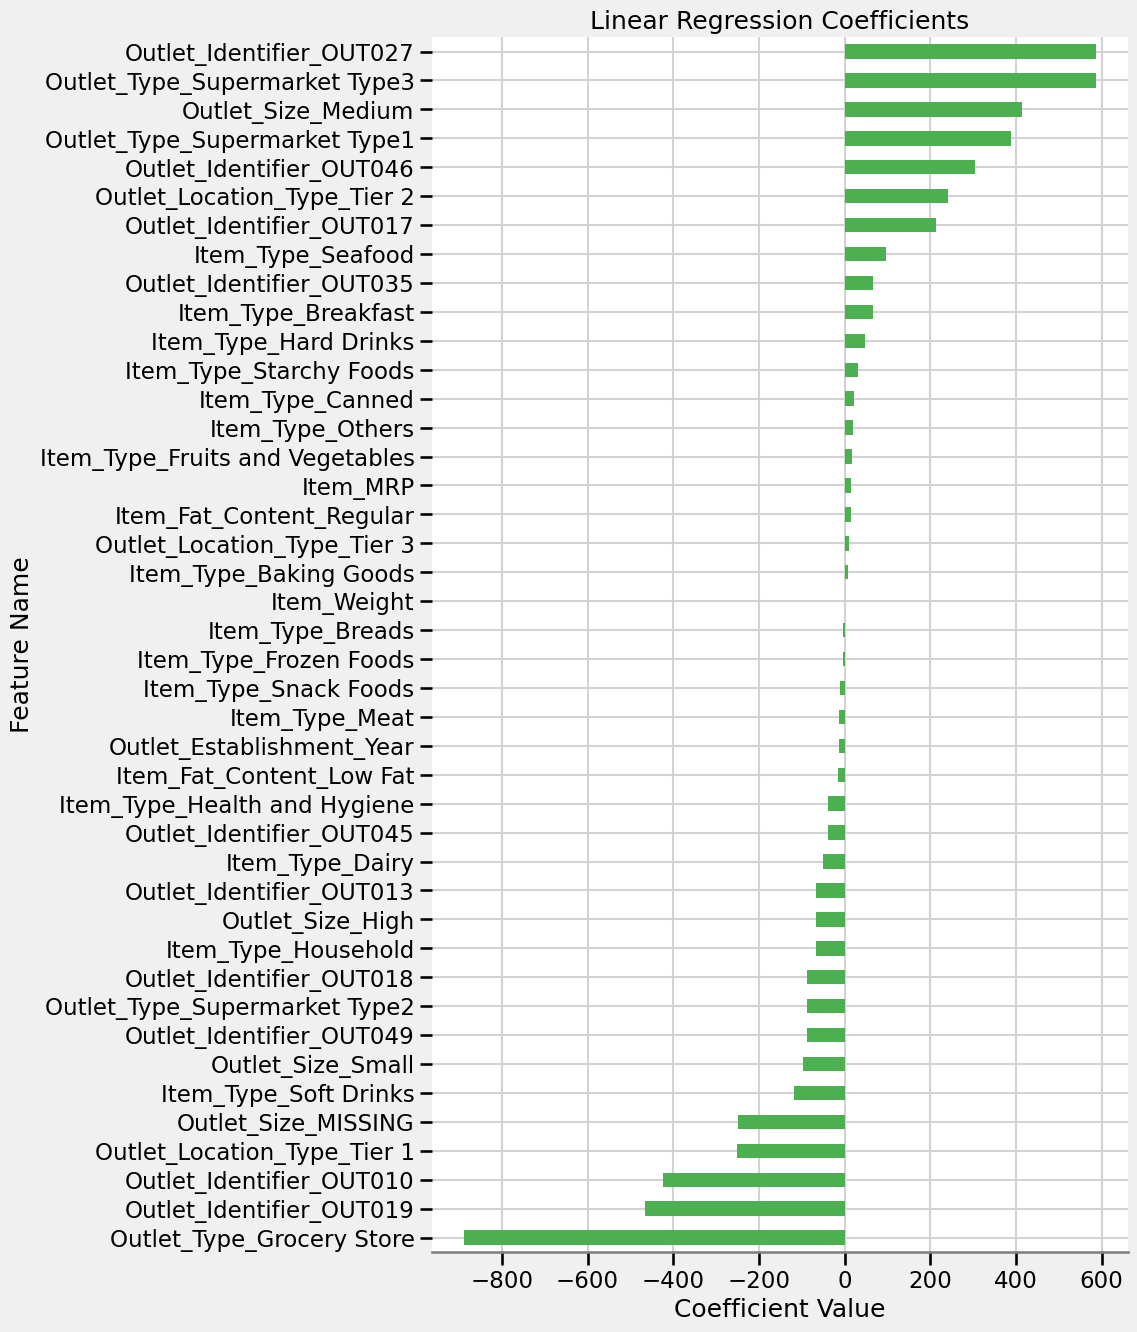

In [21]:
# Define the figure size (width, height) in inches
plt.figure(figsize=(8, 15)) 

## Plot coefficient Series with .sort_values().plot()
ax = lr_coef_df.sort_values().plot(kind='barh')
ax.set(ylabel='Feature Name',xlabel='Coefficient Value',
title='Linear Regression Coefficients');


### LinearRegression Coefficients Explained
- Top three positive coefficients
    - **"Supermarket Type 3" Outlet Type:** An outlet type of "Supermarket type 3" is predicted by our model to increase Outlet_Item_Sales by 600 rupees.
    - **Outlet Identifier 27:**  Store number 27 is predicted by our model to increase Outlet_Item_Sales by 600 rupees.
    - **"Medium" Outlet Size:** Our model predicts that Item_sales increase by about 400 rupees when the outlet is of medium size.   
      
- Top three negative coefficients        
    - **"Grocery Store" Outlet Type:** this classification has the strongest negative coefficient and our model predicts that an outlet of this type would generate 900 less rupees in sales.        
    - **Outlet Identifier 19:**  Specifically, the outlet with the identifier "OUT019is predicted to reduce Item_Sales by almost 500 rupees.
    - **Outlet Identifier 19:**  Similar to above, store 19 is predicted to reduce Item Sales predictions by just over 400 rupees.

In [22]:
from sklearn.inspection import permutation_importance

r = permutation_importance(lin_reg, X_train_df, y_train ,n_repeats =5)

## can make the mean importances into a series
perm_importances = pd.Series(r['importances_mean'],index=X_train_df.columns,
                           name = 'Linear Regression permutation importance')
perm_importances.head(20).sort_values()

Item_Type_Baking Goods            -4.714228e-06
Item_Type_Frozen Foods            -1.823096e-07
Item_Type_Breads                   1.369737e-06
Item_Type_Meat                     1.419188e-06
Item_Type_Canned                   6.434821e-06
Item_Type_Snack Foods              9.604002e-06
Item_Type_Fruits and Vegetables    1.373199e-05
Item_Type_Others                   2.183260e-05
Item_Type_Breakfast                2.934079e-05
Item_Weight                        5.058363e-05
Item_Type_Hard Drinks              5.689983e-05
Item_Type_Seafood                  6.483028e-05
Item_Fat_Content_Low Fat           7.249960e-05
Item_Fat_Content_Regular           7.249960e-05
Item_Type_Health and Hygiene       8.594391e-05
Item_Type_Dairy                    1.126586e-04
Item_Type_Household                3.111944e-04
Item_Type_Soft Drinks              3.232887e-04
Outlet_Establishment_Year          9.742747e-03
Item_MRP                           6.558867e-01
Name: Linear Regression permutation impo

In [23]:
ax = perm_importances.sort_values().plot(kind='barh',figsize=(8,15))
ax.set(ylabel='Feature Name',xlabel='Permutation Importance',
title='Linear Regression Permutation Importance');

In [24]:
## saving variables for next lesson/notebook
import joblib
## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
          "y_test": y_test,
         'preprocessor':preprocessor,
         'Linear_Regression':lin_reg}
joblib.dump(export, 'LinearRegression.joblib')

['LinearRegression.joblib']

In [25]:
# Group the data by 'Outlet_Type' and calculate the mean sales for each type
sales_by_outlet_type = df.groupby('Outlet_Type')['Item_Outlet_Sales'].mean().reset_index()

# Create a bar plot to visualize the average sales by outlet types
plt.figure(figsize=(10, 6))
plt.bar(sales_by_outlet_type['Outlet_Type'], sales_by_outlet_type['Item_Outlet_Sales'])
plt.xlabel('Outlet Type')
plt.ylabel('Item Sales')
plt.title('Average Sales by Outlet Type')
plt.xticks(rotation=45)
plt.show(); 

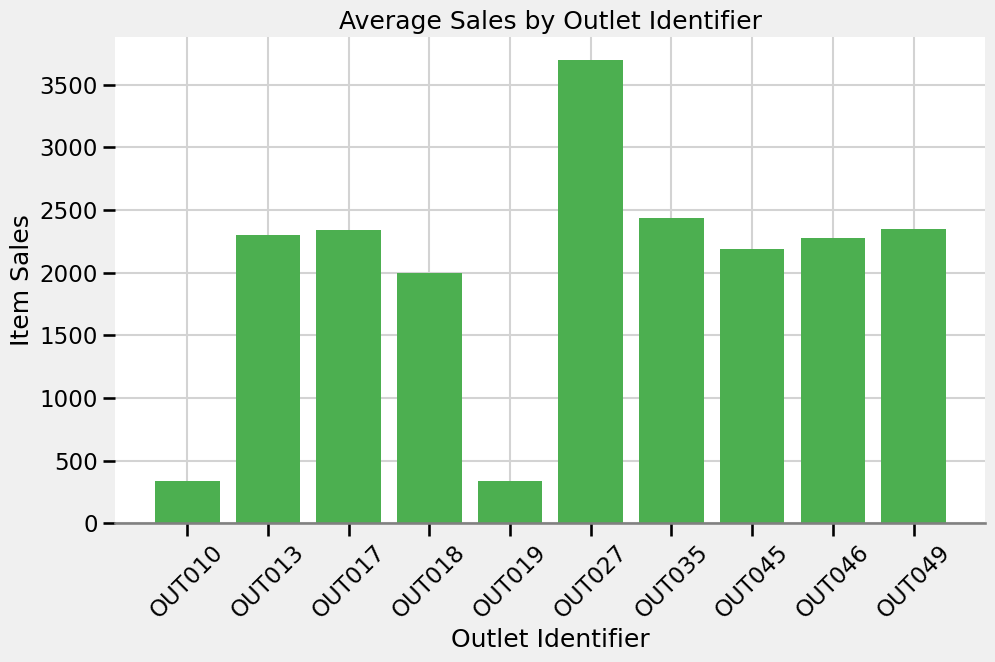

In [62]:
# Group the data by 'Outlet_Identifier' and calculate the mean sales for each store
sales_by_outlet_type = df.groupby('Outlet_Identifier')['Item_Outlet_Sales'].mean().reset_index()

# Create a bar plot to visualize the average sales by outlet
plt.figure(figsize=(10, 6))
plt.bar(sales_by_outlet_type['Outlet_Identifier'], sales_by_outlet_type['Item_Outlet_Sales'])
plt.xlabel('Outlet Identifier')
plt.ylabel('Item Sales')
plt.title('Average Sales by Outlet Identifier')
plt.xticks(rotation=45)
plt.show(); 

- Outlet 27 has the highest average Item Sales.  
- Outlets 10 and 19 have the lowest Item Sales.  

In [27]:
# Group the data by 'Outlet_Type' and calculate the mean sales for each type
sales_by_outlet_type = df.groupby('Outlet_Size')['Item_Outlet_Sales'].mean().reset_index()

# Create a bar plot to visualize the average sales by outlet types
plt.figure(figsize=(10, 6))
plt.bar(sales_by_outlet_type['Outlet_Size'], sales_by_outlet_type['Item_Outlet_Sales'])
plt.xlabel('Outlet Size')
plt.ylabel('Item Sales')
plt.title('Average Sales by Outlet Size')
plt.xticks(rotation=45)
plt.show(); 

- Medium- sized outlets have the highest Item Sales.
- Small outlets tend to have the lowest average sales.  

## XG Boost

In [28]:
import xgboost as xgb

In [29]:
pip install --upgrade xgboost pandas

Note: you may need to restart the kernel to use updated packages.


In [30]:
# Define model
xgb_reg = xgb.XGBRegressor()

# Fit model on training data
xgb_reg.fit(X_train_df,y_train)
evaluate_regression(xgb_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.85	RMSE= 656.94
Test Data:	R^2= 0.49	RMSE= 1249.49


In [31]:
feature_importance = pd.Series(xgb_reg.feature_importances_, index=feature_names,
                        name='XGBoost Feature Importances')
feature_importance.head()

Item_Weight                  0.005297
Item_MRP                     0.030717
Outlet_Establishment_Year    0.028018
Item_Fat_Content_Low Fat     0.006068
Item_Fat_Content_Regular     0.000000
Name: XGBoost Feature Importances, dtype: float32

In [32]:
## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
          "y_test": y_test,
         'preprocessor':preprocessor,
         'XGBoost': xgb_reg}
joblib.dump(export, 'XGBoost.joblib')

['XGBoost.joblib']

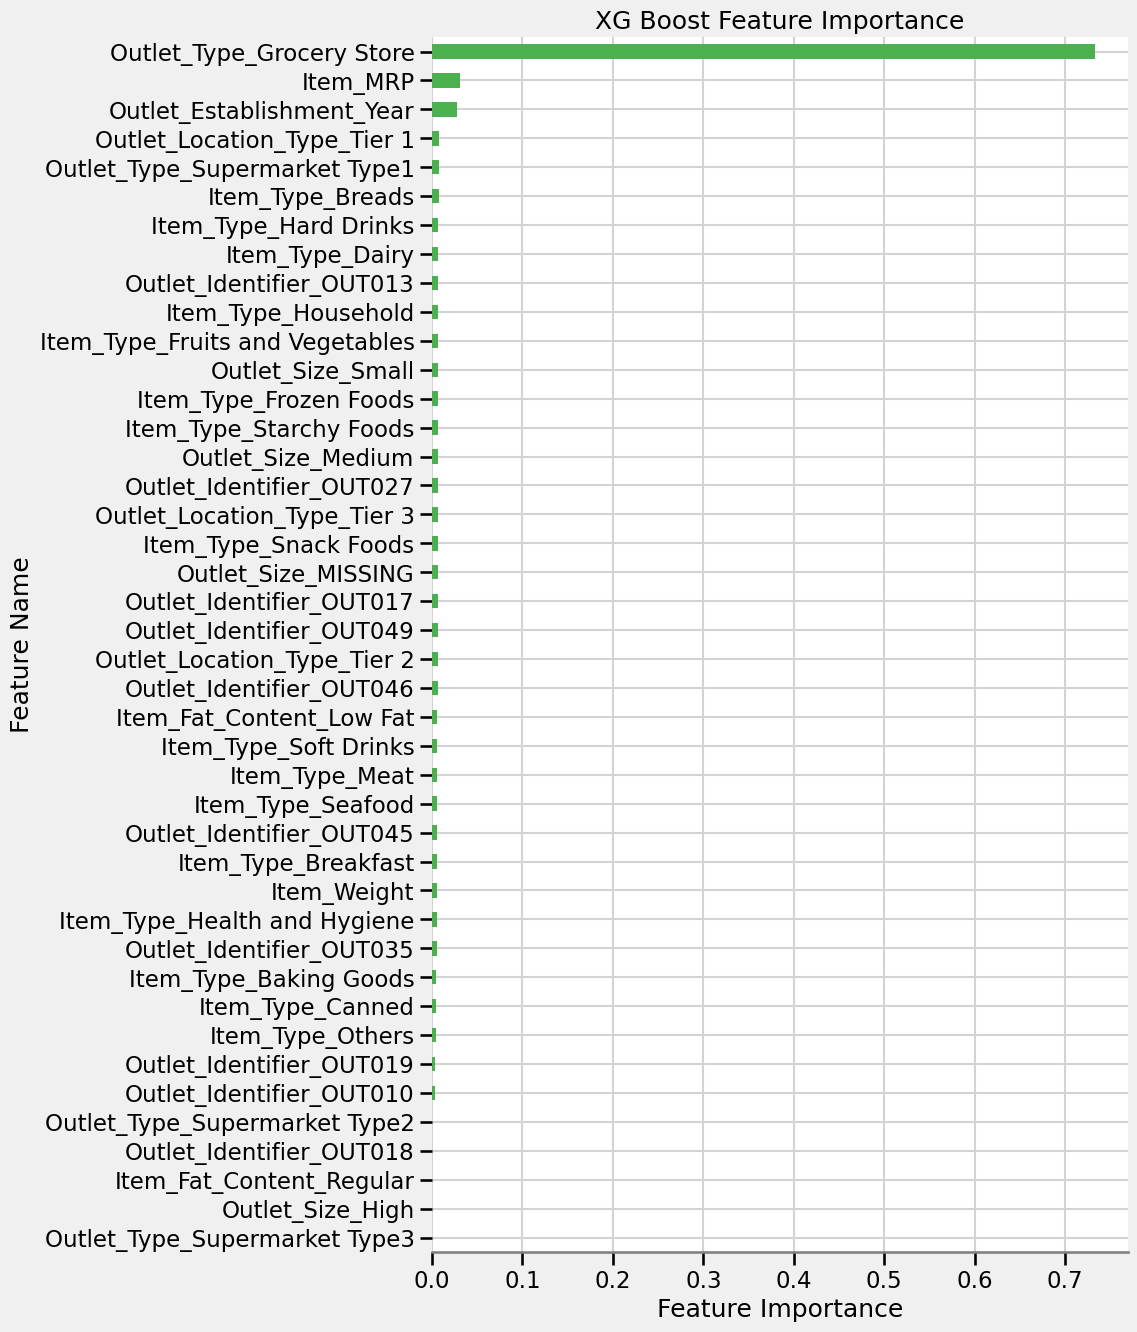

In [33]:
ax = feature_importance.sort_values().plot(kind='barh',figsize=(8,15))
ax.set(ylabel='Feature Name',xlabel='Feature Importance',
       title='XG Boost Feature Importance');



In [34]:
from sklearn.inspection import permutation_importance

r = permutation_importance(xgb_reg, X_train_df, y_train ,n_repeats =5)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [35]:
## can make the mean importances into a series
perm_importances = pd.Series(r['importances_mean'],index=X_train_df.columns,
                           name = 'permutation importance')
perm_importances.head(20).sort_values()

Item_Fat_Content_Regular           0.000000
Item_Type_Seafood                  0.001764
Item_Type_Others                   0.002030
Item_Type_Breakfast                0.005056
Item_Type_Meat                     0.005693
Item_Type_Breads                   0.006147
Item_Type_Dairy                    0.006176
Item_Type_Baking Goods             0.006913
Item_Type_Canned                   0.007288
Item_Type_Soft Drinks              0.007295
Item_Type_Hard Drinks              0.007806
Item_Type_Health and Hygiene       0.008365
Item_Type_Household                0.010207
Item_Type_Frozen Foods             0.012928
Item_Fat_Content_Low Fat           0.017057
Item_Type_Snack Foods              0.019380
Item_Type_Fruits and Vegetables    0.020643
Item_Weight                        0.151353
Outlet_Establishment_Year          0.218706
Item_MRP                           0.997255
Name: permutation importance, dtype: float64

In [36]:
ax = perm_importances.sort_values().plot(kind='barh',figsize=(8,15))
ax.set(ylabel='Feature Name',xlabel='Permutation Importance',
title='XG Boost Permutation Importance');

## Random Forest Model

In [40]:
from sklearn.ensemble import RandomForestRegressor

In [41]:
# Define the Random Forest model
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=SEED)

# Fit the model on training data
rf_reg.fit(X_train_df, y_train)

evaluate_regression(rf_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.71	RMSE= 907.59
Test Data:	R^2= 0.58	RMSE= 1137.12


In [42]:
feature_importance = pd.Series(rf_reg.feature_importances_, index=feature_names,
                        name='Random Forest Feature Importances')
feature_importance.head()

Item_Weight                  0.026226
Item_MRP                     0.536635
Outlet_Establishment_Year    0.024366
Item_Fat_Content_Low Fat     0.002180
Item_Fat_Content_Regular     0.002053
Name: Random Forest Feature Importances, dtype: float64

In [43]:
## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
          "y_test": y_test,
         'preprocessor':preprocessor,
         'RandomForest': rf_reg}
joblib.dump(export, 'RandomForest.joblib')

['RandomForest.joblib']

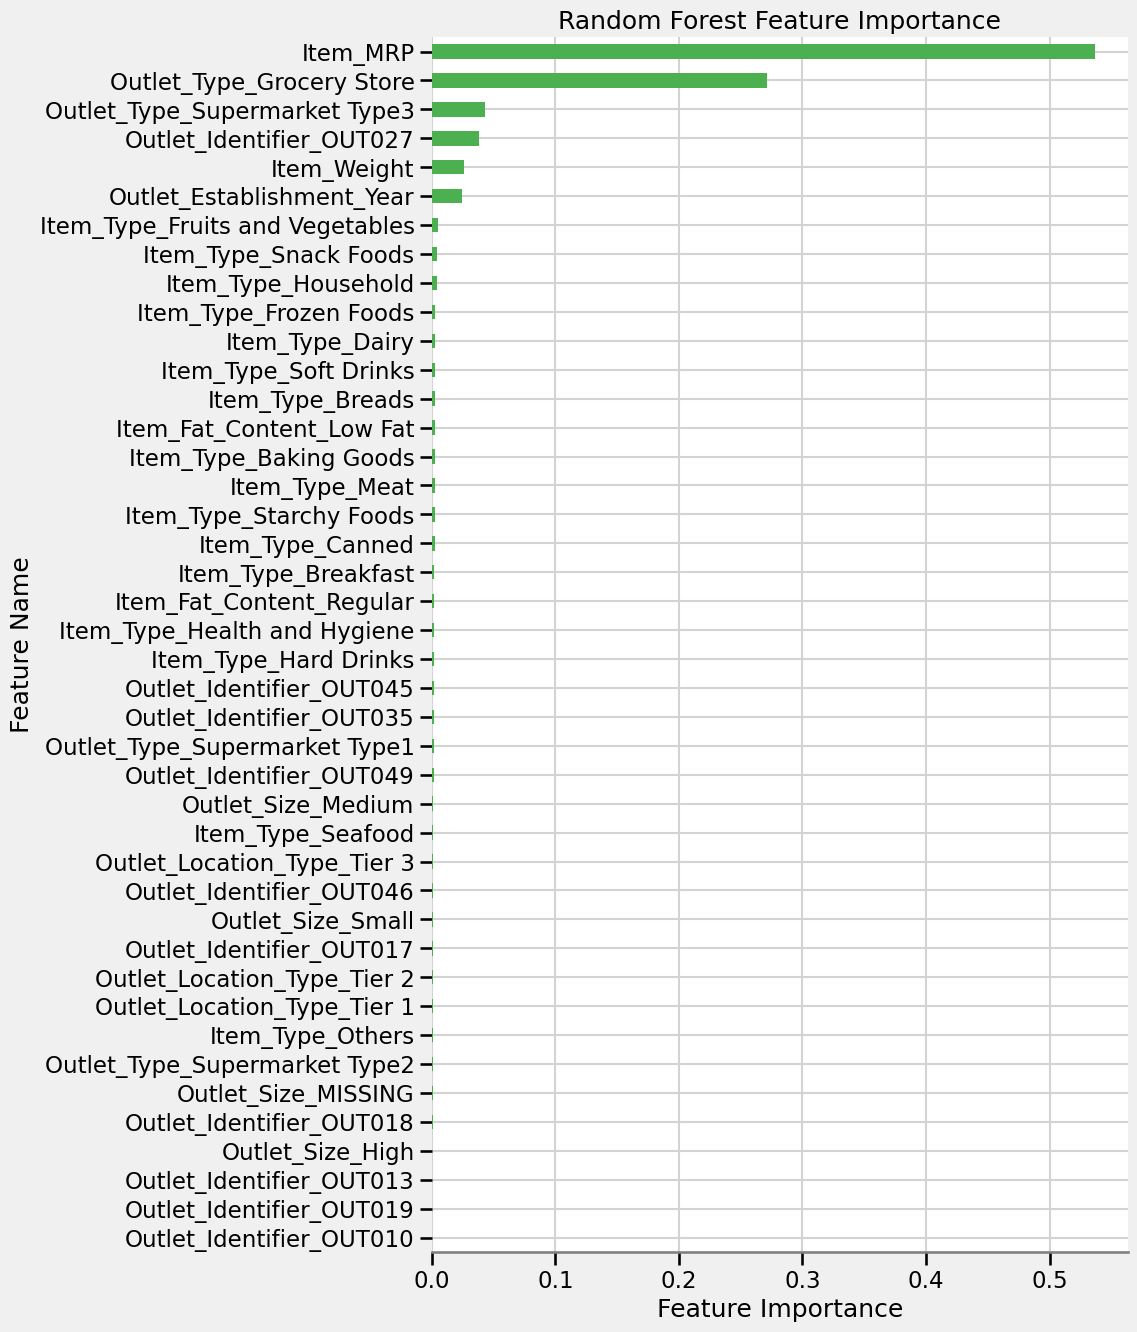

In [44]:
ax = feature_importance.sort_values().plot(kind='barh',figsize=(8,15))
ax.set(ylabel='Feature Name',xlabel='Feature Importance',
title='Random Forest Feature Importance');

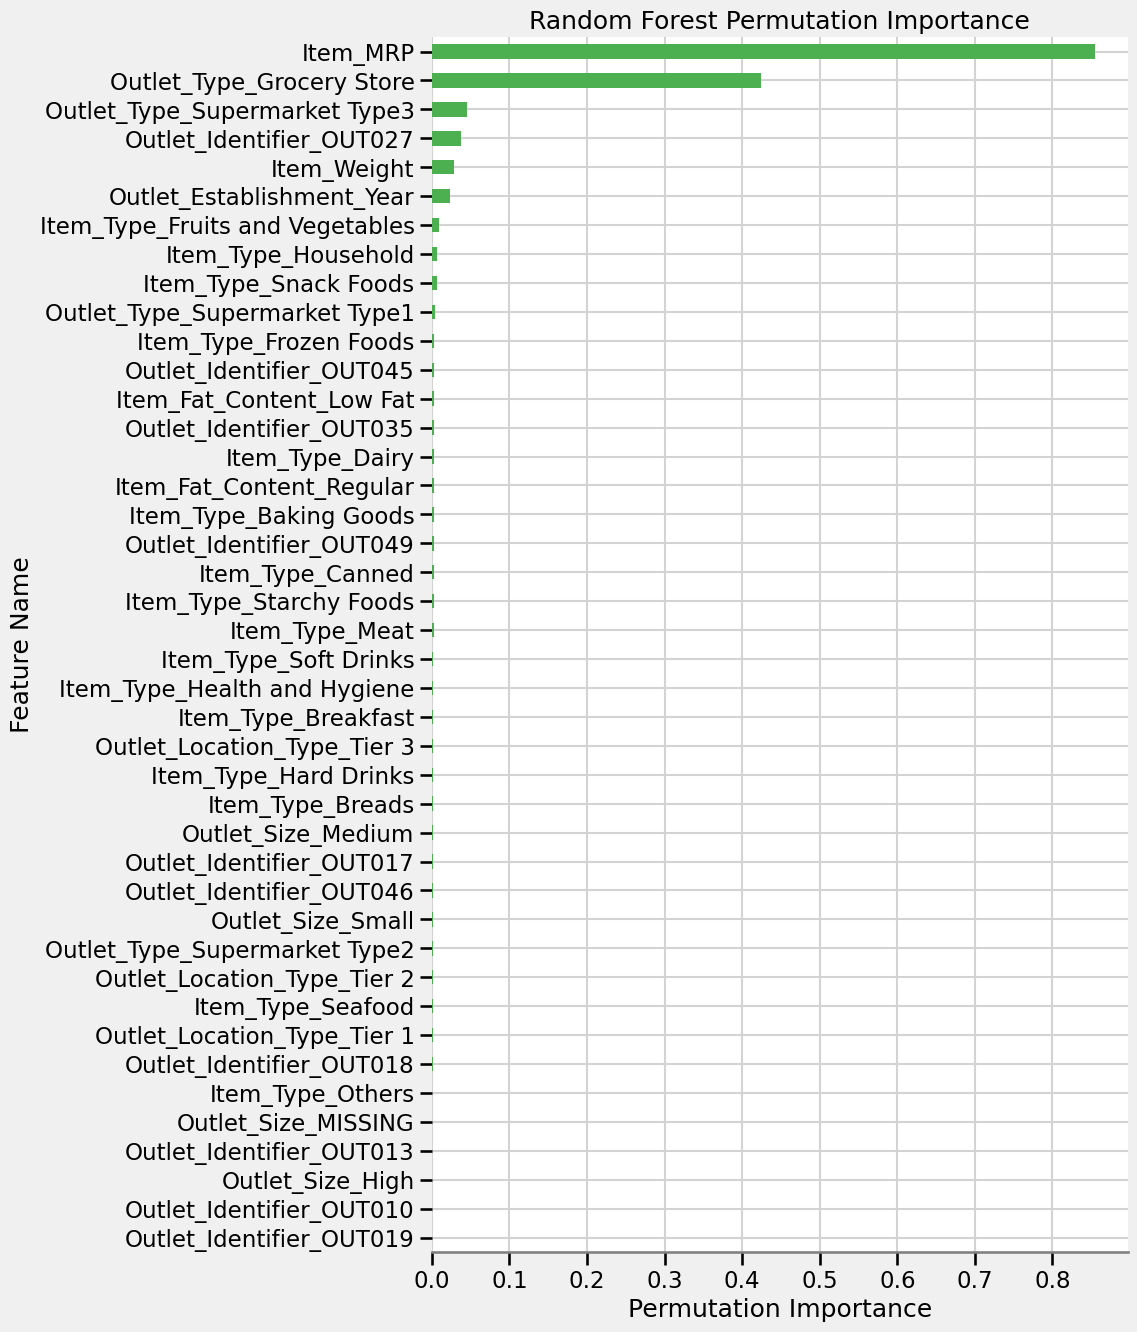

In [45]:
# Create permutation importance plot
r = permutation_importance(rf_reg, X_train_df, y_train ,n_repeats =5)

## can make the mean importances into a series
perm_importances = pd.Series(r['importances_mean'],index=X_train_df.columns,
                           name = 'Random Forest permutation importance')
perm_importances.head(20).sort_values()


ax = perm_importances.sort_values().plot(kind='barh',figsize=(8,15))
ax.set(ylabel='Feature Name',xlabel='Permutation Importance',
title='Random Forest Permutation Importance');

## Tuned Decision Tree

In [46]:
from sklearn.tree import DecisionTreeRegressor

# Create a DecisionTreeRegressor with the best hyperparameters from previous notebook
best_dt_reg = DecisionTreeRegressor(
    max_depth=5,
    min_samples_leaf=10,
    min_samples_split=2
)

# Fit the model on training data
best_dt_reg.fit(X_train_df, y_train)

evaluate_regression(best_dt_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.61	RMSE= 1060.20
Test Data:	R^2= 0.59	RMSE= 1123.41


In [47]:
feature_importance = pd.Series(best_dt_reg.feature_importances_, index=feature_names,
                        name='Random Forest Feature Importances')
feature_importance.head()

Item_Weight                  0.000056
Item_MRP                     0.550303
Outlet_Establishment_Year    0.005130
Item_Fat_Content_Low Fat     0.000049
Item_Fat_Content_Regular     0.000000
Name: Random Forest Feature Importances, dtype: float64

In [48]:
## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
          "y_test": y_test,
         'preprocessor':preprocessor,
         'TunedDecisionTree': best_dt_reg}
joblib.dump(export, 'TunedDecisionTree.joblib')

['TunedDecisionTree.joblib']

In [49]:
ax = feature_importance.sort_values().plot(kind='barh',figsize=(8,15))
ax.set(ylabel='Feature Name',xlabel='Feature Importance',
title='Tuned Decision Tree Feature Importance');

In [50]:
# Create permutation importance plot
r = permutation_importance(best_dt_reg, X_train_df, y_train ,n_repeats =5)

## can make the mean importances into a series
perm_importances = pd.Series(r['importances_mean'],index=X_train_df.columns,
                           name = 'Tuned Decision Tree permutation importance')
perm_importances.head(20).sort_values()


ax = perm_importances.sort_values().plot(kind='barh',figsize=(8,15))
ax.set(ylabel='Feature Name',xlabel='Permutation Importance',
title='Tuned Decision Tree Permutation Importance');

In [53]:
# Display Permutation Scores
perm_importances.tail(25).sort_values()

Item_Type_Seafood                0.000000
Outlet_Location_Type_Tier 3      0.000000
Outlet_Location_Type_Tier 2      0.000000
Outlet_Location_Type_Tier 1      0.000000
Outlet_Size_Small                0.000000
Outlet_Size_Medium               0.000000
Outlet_Size_MISSING              0.000000
Outlet_Size_High                 0.000000
Outlet_Identifier_OUT049         0.000000
Outlet_Type_Supermarket Type2    0.000000
Outlet_Identifier_OUT045         0.000000
Outlet_Identifier_OUT046         0.000000
Outlet_Identifier_OUT019         0.000000
Outlet_Identifier_OUT018         0.000000
Outlet_Identifier_OUT017         0.000000
Outlet_Identifier_OUT013         0.000000
Outlet_Identifier_OUT010         0.000000
Item_Type_Starchy Foods          0.000000
Item_Type_Soft Drinks            0.000000
Item_Type_Snack Foods            0.000000
Outlet_Identifier_OUT035         0.000000
Outlet_Type_Supermarket Type1    0.004903
Outlet_Identifier_OUT027         0.024871
Outlet_Type_Supermarket Type3    0

### Tuned Decision Tree Permutation Feature Importance Explained
- Top three features
    - **Item MRP (0.74):**   This feature is the highest-weighted feature used by our model to  predict Item Sales.  It is assigned a score of 0.74.
    - **Outlet Type Grocey Store (0.38):** This is the second highest-weighted feature predicted by our model with a score of 0.38.  
    - **Outlet Type Supermarket Type 3 (0.13):**  Outlets of Supermarket Type 3 are predicted to influence the predicted target by a coefficient score of 0.13, ranking this type third highest weighted feature according to the model.

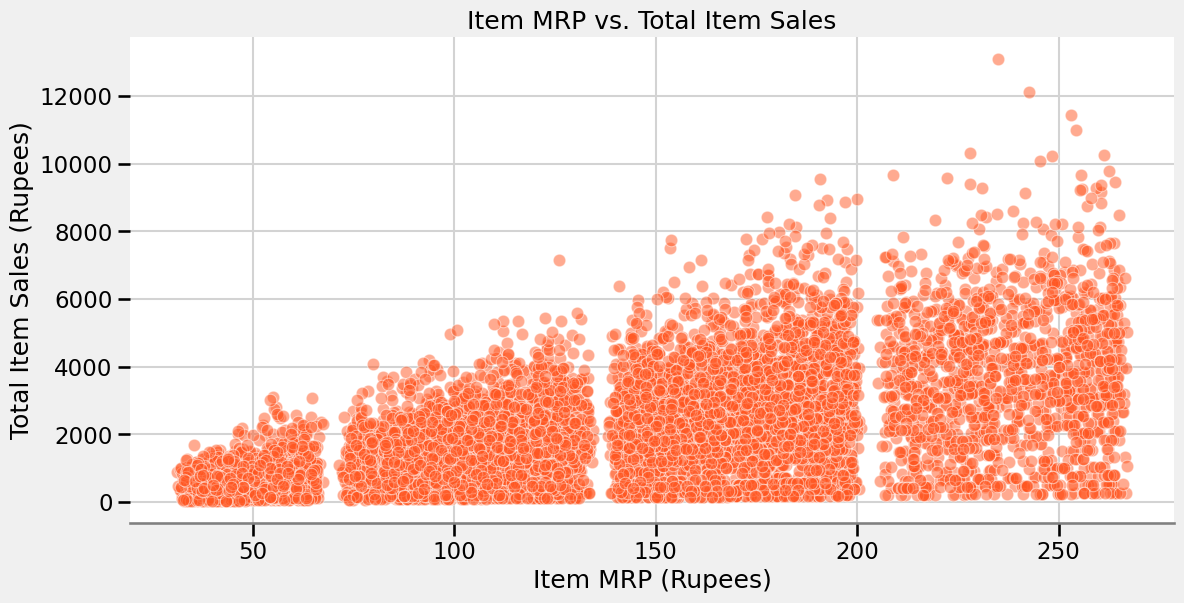

In [60]:
# Create a scatter plot for Item MRP vs. Item Sales
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Item_MRP', y='Item_Outlet_Sales', data=df, alpha=0.5, color='#FF5722')
plt.xlabel('Item MRP (Rupees)')
plt.ylabel('Total Item Sales (Rupees)')
plt.title('Item MRP vs. Total Item Sales')
plt.show(); 

- There is a positive trend of higher Item Sales as Item MRP increases.

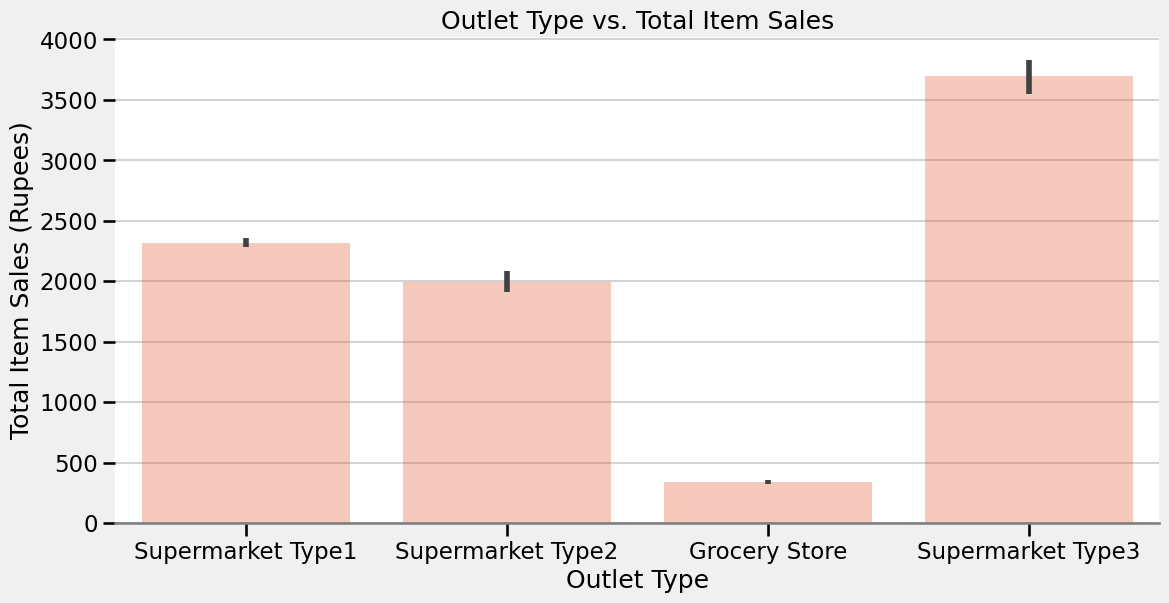

In [61]:
# Create a bar plot for Grocey Type vs. Item Sales
plt.figure(figsize=(12, 6))
sns.barplot(x='Outlet_Type', y='Item_Outlet_Sales', data=df, alpha=0.35, color='#FF5722')
plt.xlabel('Outlet Type')
plt.ylabel('Total Item Sales (Rupees)')
plt.title('Outlet Type vs. Total Item Sales')
plt.show(); 


- The figure above shows the average item sales based on Outlet Type.  Supermarket Type 3 has the highest average Item Sales of the four types while Grocery Stores have the lowest averages.  